In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_scheduler, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import autocast
from torch import GradScaler

In [15]:
MODEL_NAME       = "DeepPavlov/rubert-base-cased"
NUM_CLASSES      = 3
BATCH_SIZE       = 64
HEAD_ONLY_EPOCHS = 2
FULL_EPOCHS      = 12
PATIENCE         = 3
BASE_LR          = 2e-5
WEIGHT_DECAY     = 0.01
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# загрузка датасета рандомно
df = pd.read_pickle("tokenized_dataset.pkl")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
df.head()

,text,label,src,clean_text,input_ids,attention_mask
0,Наблюдал веселую картину: сотрудник сто чуть н...,2,geo,наблюдал веселую картину сотрудник сто чуть не...,"[101, 51120, 53086, 1790, 23459, 18040, 8590, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"После просмотра данного анимэ, странное чувств...",0,anime,"после просмотра данного анимэ, странное чувств...","[101, 3468, 37854, 17719, 22303, 900, 128, 819...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,платье велико !\n\n\n\n\n\nВиталий.\n\ne-mail:...,0,ru-reviews-classification,платье велико ! виталий. e-mail zvp2012 yandex.ru,"[101, 41361, 63990, 106, 22556, 20059, 132, 24...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"качество отвратительное, колючая. нет ни перед...",0,rureviews,"качество отвратительное, колючая. нет ни перед...","[101, 24991, 63162, 12127, 128, 46553, 1637, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Достоинства: Густая и очень вкусная Моя любима...,1,perekrestok,достоинства густая и очень вкусная моя любимая...,"[101, 30731, 110204, 851, 7805, 28884, 2630, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."


In [18]:
# деление на train test val
train_val_df, test_df = train_test_split(
    df,
    test_size=0.05,
    stratify=df["label"],
    random_state=42
)
print(f"Total: {len(df)} examples")
print(f"Train+Val: {len(train_val_df)} ({len(train_val_df)/len(df):.1%})")
print(f" Test:     {len(test_df)} ({len(test_df)/len(df):.1%})\n")

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.053,
    stratify=train_val_df["label"],
    random_state=42
)
print(f"Train: {len(train_df)} ({len(train_df)/len(df):.1%})")
print(f"  Val: {len(val_df)} ({len(val_df)/len(df):.1%})")

Total: 290458 examples
Train+Val: 275935 (95.0%)
 Test:     14523 (5.0%)

Train: 261310 (90.0%)
  Val: 14625 (5.0%)


In [19]:
def to_tensor_df(dataframe):
    dataframe["input_ids"] = dataframe["input_ids"].apply(lambda x: torch.tensor(x, dtype=torch.long))
    dataframe["attention_mask"] = dataframe["attention_mask"].apply(lambda x: torch.tensor(x, dtype=torch.long))
    dataframe["label"] = dataframe["label"].astype(int)
    return dataframe

In [20]:
train_df = to_tensor_df(train_df)
val_df = to_tensor_df(val_df)
test_df  = to_tensor_df(test_df)

In [21]:
class TextDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            "input_ids": row["input_ids"],
            "attention_mask": row["attention_mask"],
            "label": torch.tensor(row["label"], dtype=torch.long)
        }


In [22]:
train_loader = DataLoader(TextDataset(train_df), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TextDataset(val_df), batch_size=BATCH_SIZE)
test_loader = DataLoader(TextDataset(test_df), batch_size=BATCH_SIZE)

In [23]:
bert = AutoModel.from_pretrained(MODEL_NAME)
class BertClassifier(nn.Module):
    def __init__(self, bert, num_classes, dropout_p=0.3):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(dropout_p)
        self.out = nn.Linear(bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = out.last_hidden_state[:, 0]  # [B, hidden_size]
        pooled = self.dropout(cls_emb)
        return self.out(self.dropout(pooled))               # [B, num_classes]

model = BertClassifier(bert, NUM_CLASSES).to(DEVICE)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
def unfreeze_bert_layers(model, n_last_layers: int):
    # Сначала замораживаем все
    for param in model.bert.parameters():
        param.requires_grad = False

    # Размораживаем последние n_last_layers
    for i in range(12 - n_last_layers, 12):  
        for param in model.bert.encoder.layer[i].parameters():
            param.requires_grad = True

    
   
    

In [25]:
for n, p in model.named_parameters():
    if n.startswith("bert."):
        p.requires_grad = False

optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=2e-4, weight_decay=WEIGHT_DECAY
)
scaler = GradScaler()

total_steps = len(train_loader) * HEAD_ONLY_EPOCHS
sched = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


best_val_f1 = 0.0
epochs_no_improve = 0


train_losses, valid_losses = [], []
train_f1s,    val_f1s    = [], []
train_accs,   val_accs   = [], []

for epoch in range(1, HEAD_ONLY_EPOCHS+1):
    batch_losses, batch_preds, batch_labels = [], [], []
    model.train()
    for batch in tqdm(train_loader, desc=f"Head-only epoch {epoch}"):
        optimizer.zero_grad()
        ids  = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)
        lbls = batch["label"].to(DEVICE)

        with autocast("cuda"):
            outputs = model(ids, mask)
            loss    = criterion(outputs, lbls)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        sched.step()

        batch_losses.append(loss.item())
        preds = outputs.argmax(dim=1)
        batch_preds.extend(preds.cpu().tolist()) 
        batch_labels.extend(lbls.cpu().tolist())

    avg_train_loss = sum(batch_losses) / len(batch_losses)
    train_acc      = accuracy_score(batch_labels, batch_preds)
    train_f1       = f1_score(batch_labels, batch_preds, average="macro")
    print(f"[Train] Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")    

    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    

    # — VAL —
    model.eval()
    val_preds, val_labels, val_losses = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            ids  = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            lbls = batch["label"].to(DEVICE)

            outputs = model(ids, mask)
            loss    = criterion(outputs, lbls)

            val_losses.append(loss.item())
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(lbls.cpu().tolist())

    avg_val_loss = sum(val_losses) / len(val_losses)
    val_acc      = accuracy_score(val_labels, val_preds)
    val_f1       = f1_score(val_labels, val_preds, average="macro")
    print(f"  [Val]   Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    valid_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_bert_finetuned.pt")
        print("  ✓ New best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve > PATIENCE:
            print("Early stopping")
            break


Head-only epoch 1: 100%|██████████| 4083/4083 [08:42<00:00,  7.82it/s]


[Train] Loss: 0.9872 | Acc: 0.5326 | F1: 0.5303
  [Val]   Loss: 0.9193 | Acc: 0.6102 | F1: 0.6098
  ✓ New best model saved.


Head-only epoch 2: 100%|██████████| 4083/4083 [08:44<00:00,  7.79it/s]


[Train] Loss: 0.9503 | Acc: 0.5743 | F1: 0.5720
  [Val]   Loss: 0.9140 | Acc: 0.6142 | F1: 0.6108
  ✓ New best model saved.


In [26]:
for p in model.bert.parameters():
    p.requires_grad = True

optimizer = AdamW(model.parameters(), lr=BASE_LR, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * (FULL_EPOCHS - HEAD_ONLY_EPOCHS)
sched = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

best_val_f1 = 0.0
epochs_no_improve = 0


for epoch in range(HEAD_ONLY_EPOCHS+1, FULL_EPOCHS+1):
    # — TRAIN —

    if epoch == 0:
        unfreeze_bert_layers(model, 0)  # только head
    elif epoch == 3:
        unfreeze_bert_layers(model, 2)  # слои 10–11
    elif epoch == 5:
        unfreeze_bert_layers(model, 5)  # слои 7–11
    elif epoch == 7:
        unfreeze_bert_layers(model, 12) # все

    model.train()
    batch_losses, batch_preds, batch_labels = [], [], []
    for batch in tqdm(train_loader, desc=f"Head-only epoch {epoch}"):
        optimizer.zero_grad()
        ids  = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)
        lbls = batch["label"].to(DEVICE)

        with autocast("cuda"):
            outputs = model(ids, mask)
            loss    = criterion(outputs, lbls)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        sched.step()

        batch_losses.append(loss.item())
        preds = outputs.argmax(dim=1)
        batch_preds.extend(preds.cpu().tolist())
        batch_labels.extend(lbls.cpu().tolist())

    avg_train_loss = sum(batch_losses) / len(batch_losses)
    train_acc      = accuracy_score(batch_labels, batch_preds)
    train_f1       = f1_score(batch_labels, batch_preds, average="macro")
    print(f"[Train] Loss: {avg_train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")    

    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    train_f1s.append(train_f1)
    

    # — VAL —
    model.eval()
    val_preds, val_labels, val_losses = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            ids  = batch["input_ids"].to(DEVICE)
            mask = batch["attention_mask"].to(DEVICE)
            lbls = batch["label"].to(DEVICE)

            outputs = model(ids, mask)
            loss    = criterion(outputs, lbls)

            val_losses.append(loss.item())
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(lbls.cpu().tolist())

    avg_val_loss = sum(val_losses) / len(val_losses)
    val_acc      = accuracy_score(val_labels, val_preds)
    val_f1       = f1_score(val_labels, val_preds, average="macro")
    print(f"  [Val]   Loss: {avg_val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    val_losses.append(avg_val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_bert_finetuned.pt")
        print("  ✓ New best model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve > PATIENCE:
            print("Early stopping")
            break

Head-only epoch 3: 100%|██████████| 4083/4083 [11:49<00:00,  5.76it/s]


[Train] Loss: 0.8597 | Acc: 0.6362 | F1: 0.6346
  [Val]   Loss: 0.7741 | Acc: 0.6916 | F1: 0.6921
  ✓ New best model saved.


Head-only epoch 4: 100%|██████████| 4083/4083 [11:53<00:00,  5.73it/s]


[Train] Loss: 0.7708 | Acc: 0.6951 | F1: 0.6950
  [Val]   Loss: 0.7430 | Acc: 0.7143 | F1: 0.7124
  ✓ New best model saved.


Head-only epoch 5: 100%|██████████| 4083/4083 [16:54<00:00,  4.03it/s]


[Train] Loss: 0.7349 | Acc: 0.7194 | F1: 0.7194
  [Val]   Loss: 0.7164 | Acc: 0.7331 | F1: 0.7284
  ✓ New best model saved.


Head-only epoch 6: 100%|██████████| 4083/4083 [16:52<00:00,  4.03it/s]


[Train] Loss: 0.6996 | Acc: 0.7444 | F1: 0.7444
  [Val]   Loss: 0.7026 | Acc: 0.7416 | F1: 0.7408
  ✓ New best model saved.


Head-only epoch 7: 100%|██████████| 4083/4083 [28:38<00:00,  2.38it/s]


[Train] Loss: 0.6776 | Acc: 0.7589 | F1: 0.7590
  [Val]   Loss: 0.6937 | Acc: 0.7479 | F1: 0.7523
  ✓ New best model saved.


Head-only epoch 8: 100%|██████████| 4083/4083 [29:15<00:00,  2.33it/s]


[Train] Loss: 0.6394 | Acc: 0.7870 | F1: 0.7870
  [Val]   Loss: 0.6820 | Acc: 0.7573 | F1: 0.7585
  ✓ New best model saved.


Head-only epoch 9: 100%|██████████| 4083/4083 [28:41<00:00,  2.37it/s]


[Train] Loss: 0.6031 | Acc: 0.8137 | F1: 0.8137
  [Val]   Loss: 0.6935 | Acc: 0.7603 | F1: 0.7595
  ✓ New best model saved.


Head-only epoch 10: 100%|██████████| 4083/4083 [28:36<00:00,  2.38it/s]


[Train] Loss: 0.5695 | Acc: 0.8368 | F1: 0.8368
  [Val]   Loss: 0.7103 | Acc: 0.7592 | F1: 0.7591


Head-only epoch 11: 100%|██████████| 4083/4083 [28:36<00:00,  2.38it/s]


[Train] Loss: 0.5412 | Acc: 0.8564 | F1: 0.8564
  [Val]   Loss: 0.7256 | Acc: 0.7580 | F1: 0.7576


Head-only epoch 12: 100%|██████████| 4083/4083 [28:31<00:00,  2.39it/s]


[Train] Loss: 0.5197 | Acc: 0.8708 | F1: 0.8708
  [Val]   Loss: 0.7406 | Acc: 0.7579 | F1: 0.7574


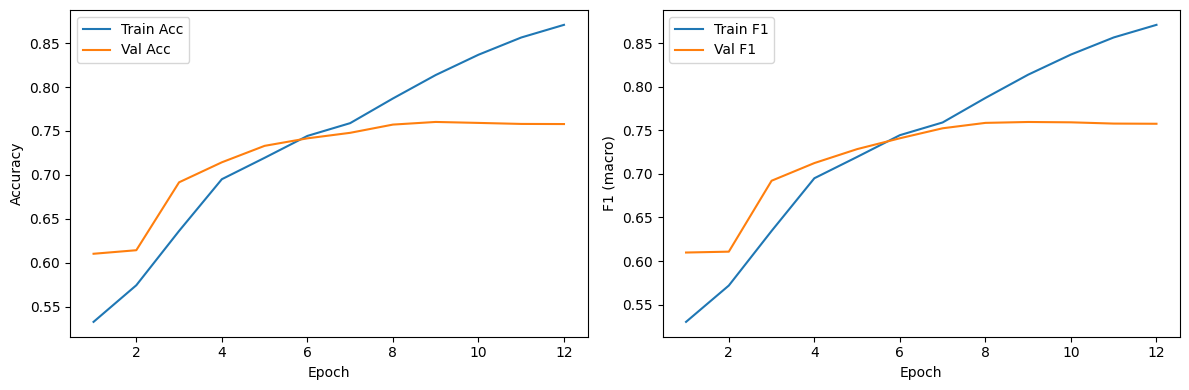

In [27]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses)+1))
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_accs,  label="Train Acc")
plt.plot(epochs, val_accs,    label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_f1s,   label="Train F1")
plt.plot(epochs, val_f1s,     label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1 (macro)")
plt.legend()

plt.tight_layout()
plt.show()

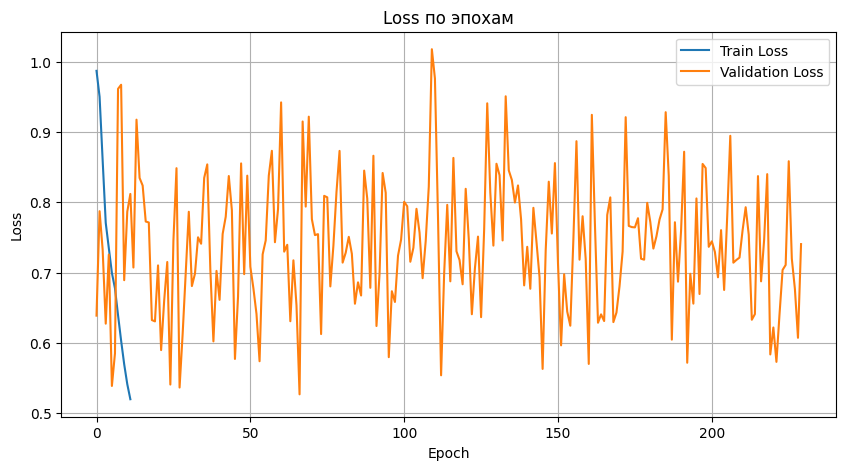

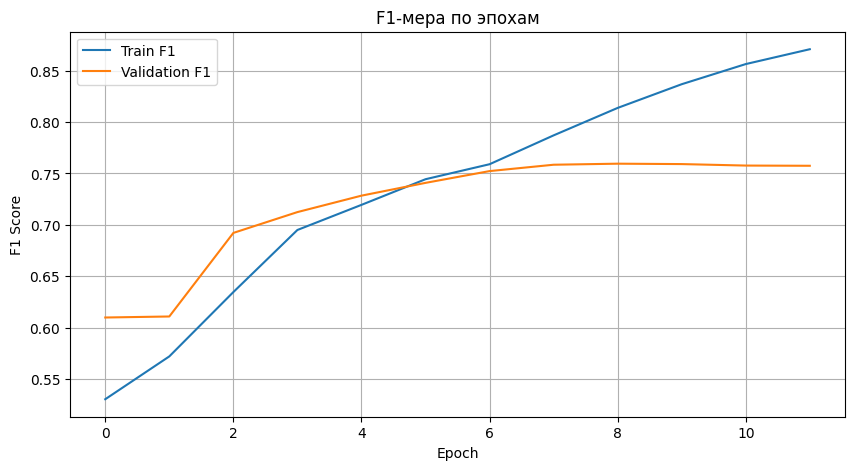

In [36]:
# --- График Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss по эпохам")
plt.legend()
plt.grid(True)
plt.show()

# --- График F1 ---
plt.figure(figsize=(10, 5))
plt.plot(train_f1s, label="Train F1")
plt.plot(val_f1s, label="Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1-мера по эпохам")
plt.legend()
plt.grid(True)
plt.show()

Test: 100%|██████████| 227/227 [01:21<00:00,  2.77it/s]

=== Test set results ===
Accuracy : 0.7579
Precision: 0.7576
Recall   : 0.7578
F1 (macro): 0.7575

Classification report:
              precision    recall  f1-score   support

           0     0.6711    0.6513    0.6611      4829
           1     0.8585    0.8483    0.8534      4844
           2     0.7430    0.7738    0.7581      4850

    accuracy                         0.7579     14523
   macro avg     0.7576    0.7578    0.7575     14523
weighted avg     0.7577    0.7579    0.7576     14523



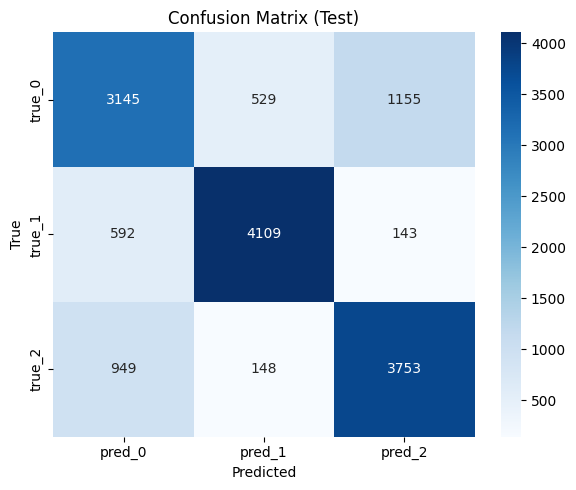

In [30]:
model = BertClassifier(bert, NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("best_bert_finetuned.pt"))
model.eval()

test_preds, test_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        input_ids      = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels         = batch["label"].to(DEVICE)

        outputs = model(input_ids, attention_mask)      
        preds   = torch.argmax(outputs, dim=1)          

        test_preds .extend(preds.cpu().tolist())        
        test_labels.extend(labels.cpu().tolist())       

acc   = accuracy_score(test_labels, test_preds)
prec  = precision_score(test_labels, test_preds, average='macro')
rec   = recall_score(test_labels, test_preds,    average='macro')
f1    = f1_score(test_labels, test_preds,        average='macro')

print("=== Test set results ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 (macro): {f1:.4f}\n")

print("Classification report:")
print(classification_report(test_labels, test_preds, digits=4))

# матрица ошибок
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"pred_{i}" for i in range(NUM_CLASSES)],
            yticklabels=[f"true_{i}" for i in range(NUM_CLASSES)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()